In [146]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
from tensorflow.keras.layers import Conv1D, MaxPooling1D

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

sequence_length = 30
prediction_days = 30
test_ticker = '^GSPC'

end_date = datetime.now()
start_date = end_date - timedelta(days=100)
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)
print(f"S&P 500 data shape: {sp500_data.shape}")

ticker_data = yf.download(test_ticker, start=start_date, end=end_date)
print(f"{test_ticker} data shape: {ticker_data.shape}")

def preprocess_data(data, feature='Close'):
    prices = data[feature].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(prices)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data) - prediction_days):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i:i+prediction_days, 0])

    return np.array(X), np.array(y), scaler

def remove_noise(data, window=5):
    data['Close'] = data['Close'].rolling(window=window).mean()
    return data.dropna()

sp500_data = remove_noise(sp500_data)
ticker_data = remove_noise(ticker_data)

X_sp500, y_sp500, scaler_sp500 = preprocess_data(sp500_data)

X_ticker, y_ticker, scaler_ticker = preprocess_data(ticker_data)

# train on full sp500 data
X_train = np.reshape(X_sp500, (X_sp500.shape[0], X_sp500.shape[1], 1))
y_train = y_sp500

X_ticker = np.reshape(X_ticker, (X_ticker.shape[0], X_ticker.shape[1], 1))
y_ticker = y_ticker

# split = int(0.8 * len(X_sp500))
# X_train, X_val = X_sp500[:split], X_sp500[split:]
# y_train, y_val = y_sp500[:split], y_sp500[split:]

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
# X_ticker = np.reshape(X_ticker, (X_ticker.shape[0], X_ticker.shape[1], 1))

def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=prediction_days))

    # model = Sequential()
    # model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)))
    # model.add(MaxPooling1D(pool_size=2))
    # model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
    # model.add(Dense(prediction_days))

    # model = Sequential()
    # model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
    # model.add(Dropout(0.2))


    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model()
print("Training model on S&P 500 data...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    # validation_data=(X_val, y_val),
    verbose=1
)

# val_predictions = model.predict(X_val)
# val_mse = mean_squared_error(y_val, val_predictions)
# val_rmse = math.sqrt(val_mse)
# val_mae = mean_absolute_error(y_val, val_predictions)
# print(f"Validation RMSE: {val_rmse:.4f}")
# print(f"Validation MAE: {val_mae:.4f}")

ticker_predictions = model.predict(X_ticker)

ticker_mse = mean_squared_error(y_ticker, ticker_predictions)
ticker_rmse = math.sqrt(ticker_mse)
ticker_mae = mean_absolute_error(y_ticker, ticker_predictions)
print(f"\n{test_ticker} Test RMSE: {ticker_rmse:.4f}")
print(f"{test_ticker} Test MAE: {ticker_mae:.4f}")

def predict_next_30_days(ticker_symbol, model, sequence_length=30):
    ticker_recent = yf.download(ticker_symbol, start=end_date-timedelta(days=100), end=end_date)
    ticker_recent = remove_noise(ticker_recent)

    recent_prices = ticker_recent['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(recent_prices)

    input_data = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)

    predicted_scaled = model.predict(input_data)[0]

    predicted_prices = scaler.inverse_transform(
        np.concatenate([predicted_scaled.reshape(-1, 1),
                         np.zeros((prediction_days, 0))], axis=1))[:, 0]

    last_date = ticker_recent.index[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(prediction_days)]

    predictions_df = pd.DataFrame(
        data=predicted_prices,
        index=future_dates,
        columns=['Predicted_Close']
    )

    return predictions_df

future_predictions = predict_next_30_days(test_ticker, model)
print(f"\nPredictions for {test_ticker} for the next 30 days:")
print(future_predictions)

print("\nSummary:")
print(f"Model trained on: S&P 500 data")
print(f"Sequence length: {sequence_length} days")
print(f"Prediction horizon: {prediction_days} days")
print(f"Test ticker: {test_ticker}")
# print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE on {test_ticker}: {ticker_rmse:.4f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

S&P 500 data shape: (68, 5)
^GSPC data shape: (68, 5)
Training model on S&P 500 data...
Epoch 1/20


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2652
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2395
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2404
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2257
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2018
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2095
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1952
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1689
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1672
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1896
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1570
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1472
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1308
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1297
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1080
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/s

[*********************100%***********************]  1 of 1 completed


^GSPC Test RMSE: 0.2488
^GSPC Test MAE: 0.1918


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step

Predictions for ^GSPC for the next 30 days:
            Predicted_Close
2025-04-05      5802.169397
2025-04-06      5709.416080
2025-04-07      5717.017993
2025-04-08      5616.329286
2025-04-09      5804.140085
2025-04-10      5713.629017
2025-04-11      5660.983811
2025-04-12      5569.899774
2025-04-13      5554.047801
2025-04-14      5704.566767
2025-04-15      5744.598476
2025-04-16      5641.771326
2025-04-17      5553.811997
2025-04-18      5489.456067
2025-04-19      5554.521180
2025-04-20      5576.433676
2025-04-21      5474.869362
2025-04-22      5543.651713
2025-04-23      5609.254467
2025-04-24      5578.714281
2025-04-25      5552.304904
2025-04-26      5566.495346
2025-04-27      5461.408568
2025-04-28      5635.866706
2025-04-29      5685.958714
2025-04-30      5517.958513
2025-05-01      5556.144447
2025-05-02      5629.992856
2025-05-03      5571.828713
2025-05-04      5566.045839

Summary:
Model trained on: S&P 500 data
Sequenc

[*********************100%***********************]  1 of 1 completed

Fetching data from 2024-12-26 14:38:55.275065 to 2025-04-05 14:38:55.275065
S&P 500 data shape: (68, 5)
S&P 500 date range: 2024-12-26 00:00:00 to 2025-04-04 00:00:00
Latest S&P 500 Close: 5074.08
Training model on S&P 500 data...
Epoch 1/10


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 884ms/step - loss: 0.7067 - val_loss: 0.0613
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.4454 - val_loss: 0.0301
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2262 - val_loss: 0.0140
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1025 - val_loss: 0.0157
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0574 - val_loss: 0.0318
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0805 - val_loss: 0.0342
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0691 - val_loss: 0.0250
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0480 - val_loss: 0.0171
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0503 - val_loss: 0.0138
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0469 - val_loss: 0.0135
Last known price (2025-04-04): $5477.30


[*********************100%***********************]  1 of 1 completed


Predictions for ^GSPC for the next 30 days:
            Predicted_Close
2025-04-05      5646.482422
2025-04-06      5641.133301
2025-04-07      5637.076660
2025-04-08      5633.991699
2025-04-09      5631.535156
2025-04-10      5629.746094
2025-04-11      5628.322754
2025-04-12      5627.022461
2025-04-13      5626.013672
2025-04-14      5625.212891
2025-04-15      5624.761719
2025-04-16      5624.688965
2025-04-17      5624.874023
2025-04-18      5625.068848
2025-04-19      5625.742676

Summary:
Model trained on: S&P 500 data
Latest S&P 500 Close: 5074.08
First predicted value: 5646.48
Sequence length: 15 days
Prediction horizon: 15 days
Test ticker: ^GSPC
Validation RMSE: 0.1173

Testing on AAPL...
Latest AAPL close: $212.16
Last known price (2025-04-04): $212.16


First predicted value: $4808.87


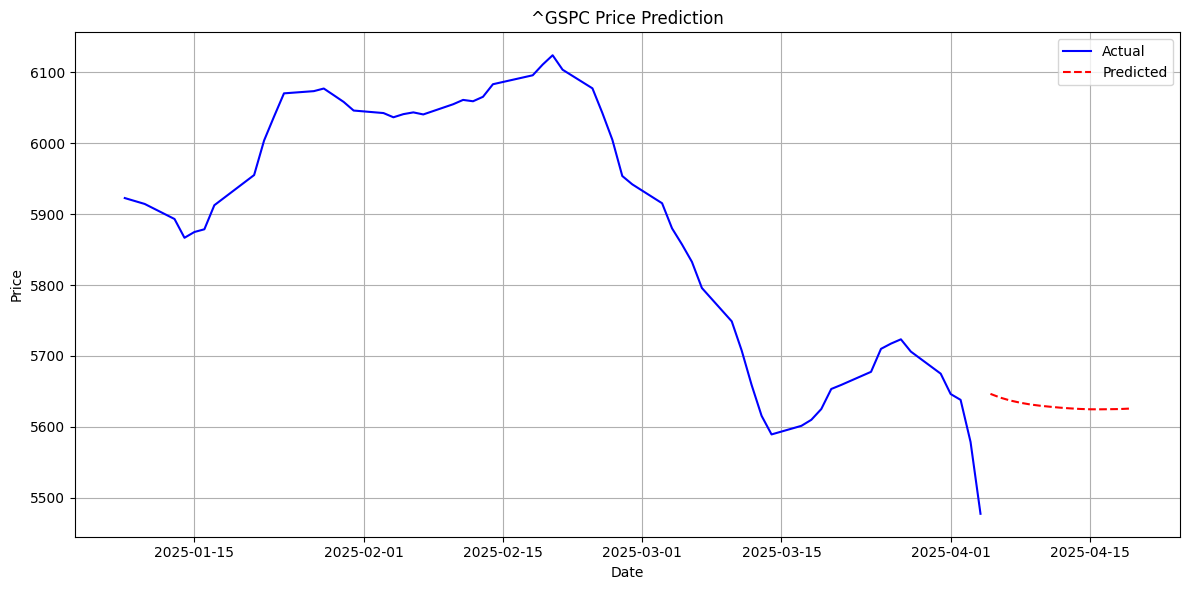

In [156]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

sequence_length = 15
prediction_days = 15
test_ticker = '^GSPC'

end_date = datetime.now()
start_date = end_date - timedelta(days=100)
print(f"Fetching data from {start_date} to {end_date}")

sp500_data = yf.download('^GSPC', start=start_date, end=end_date)
print(f"S&P 500 data shape: {sp500_data.shape}")
print(f"S&P 500 date range: {sp500_data.index[0]} to {sp500_data.index[-1]}")
print(f"Latest S&P 500 Close: {float(sp500_data['Close'].iloc[-1]):.2f}")

def remove_noise(data, window=5):
    data_copy = data.copy()
    data_copy['Close'] = data_copy['Close'].rolling(window=window).mean()
    return data_copy.dropna()

sp500_data_processed = remove_noise(sp500_data)

global_scaler = MinMaxScaler(feature_range=(0, 1))
global_scaler.fit(sp500_data_processed['Close'].values.reshape(-1, 1))

def create_sequences(data, scaler, seq_length=15):
    scaled_data = scaler.transform(data['Close'].values.reshape(-1, 1))
    X, y = [], []

    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i, 0])
        y.append(scaled_data[i, 0])

    return np.array(X), np.array(y)

X, y = create_sequences(sp500_data_processed, global_scaler, sequence_length)

split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

def build_model():
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model()
print("Training model on S&P 500 data...")
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# val_predictions = model.predict(X_val)
# val_mse = mean_squared_error(y_val, val_predictions)
# val_rmse = math.sqrt(val_mse)
# val_mae = mean_absolute_error(y_val, val_predictions)
# print(f"Validation RMSE: {val_rmse:.4f}")
# print(f"Validation MAE: {val_mae:.4f}")

def predict_future(ticker_data, model, scaler, days=15, sequence_length=15):
    last_sequence = ticker_data['Close'].values[-sequence_length:]
    last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1)).flatten()

    predictions = list(last_sequence)
    predictions_scaled = list(last_sequence_scaled)

    last_date = ticker_data.index[-1]
    last_price = float(ticker_data['Close'].iloc[-1])
    print(f"Last known price ({last_date.strftime('%Y-%m-%d')}): ${last_price:.2f}")

    future_dates = []
    future_predictions = []

    for i in range(days):
        input_seq = np.array(predictions_scaled[-sequence_length:]).reshape(1, sequence_length, 1)

        next_pred_scaled = model.predict(input_seq, verbose=0)[0][0]

        predictions_scaled.append(next_pred_scaled)

        next_pred = scaler.inverse_transform(
            np.array(next_pred_scaled).reshape(1, -1))[0][0]

        predictions.append(next_pred)

        next_date = last_date + timedelta(days=i+1)
        future_dates.append(next_date)
        future_predictions.append(next_pred)

    predictions_df = pd.DataFrame(
        data=future_predictions,
        index=future_dates,
        columns=['Predicted_Close']
    )

    return predictions_df

recent_sp500 = sp500_data_processed

future_predictions = predict_future(
    recent_sp500, model, global_scaler,
    days=prediction_days, sequence_length=sequence_length
)

print(f"\nPredictions for {test_ticker} for the next 30 days:")
print(future_predictions)

plt.figure(figsize=(12, 6))
plt.plot(recent_sp500.index[-60:], recent_sp500['Close'].iloc[-60:], 'b-', label='Actual')
plt.plot(future_predictions.index, future_predictions['Predicted_Close'], 'r--', label='Predicted')
plt.title(f"{test_ticker} Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

print("\nSummary:")
print(f"Model trained on: S&P 500 data")
print(f"Latest S&P 500 Close: {float(sp500_data['Close'].iloc[-1]):.2f}")
print(f"First predicted value: {float(future_predictions['Predicted_Close'].iloc[0]):.2f}")
print(f"Sequence length: {sequence_length} days")
print(f"Prediction horizon: {prediction_days} days")
print(f"Test ticker: {test_ticker}")
print(f"Validation RMSE: {val_rmse:.4f}")

def test_on_ticker(ticker_symbol, model, scaler, days=30, seq_length=30):
    print(f"\nTesting on {ticker_symbol}...")
    ticker_data = yf.download(ticker_symbol,
                              start=end_date-timedelta(days=300),
                              end=end_date)
    ticker_processed = remove_noise(ticker_data)

    if len(ticker_processed) < seq_length:
        print(f"Not enough data for {ticker_symbol}")
        return None

    print(f"Latest {ticker_symbol} close: ${float(ticker_processed['Close'].iloc[-1]):.2f}")

    predictions = predict_future(ticker_processed, model, scaler, days, seq_length)
    print(f"First predicted value: ${float(predictions['Predicted_Close'].iloc[0]):.2f}")

    return predictions

transfer_ticker = 'AAPL'
transfer_predictions = test_on_ticker(transfer_ticker, model, global_scaler)